In [232]:
using Plots

include("src/loader.jl")
include("src/solver.jl")
include("src/simulator.jl")
include("src/dynamic.jl")
include("src/profile_generator.jl")
include("src/classifier.jl")

filename = "data/profiles.csv";

In [233]:
period_length = 48;

load_new = true;

if load_new
    time_by_week, wind_by_week, solar_by_week = load_by_periods(filename, period_length);
    time_train, wind_train, solar_train, time_val_full, wind_val_full, solar_val_full = 
    train_val_split(time_by_week, wind_by_week, solar_by_week);
end;

In [234]:
N_CLASSES = 10;
classification_function = classify_kmeans

classes_probas, classes_train, classes_val = classification_function(wind_train, solar_train, wind_val_full, solar_val_full, N_CLASSES);

# Count the number of profiles in each class in the training set and validation set
count_classes_train = [sum(classes_train .== i) for i in 1:N_CLASSES]
count_classes_val = [sum(classes_val .== i) for i in 1:N_CLASSES]

println("Number of profiles in each class in the training set: ", count_classes_train)
println("Number of profiles in each class in the validation set: ", count_classes_val)

Shape of the data(48, 731)
Number of profiles in each class in the training set: [72, 33, 117, 116, 76, 35, 34, 63, 147, 38]
Number of profiles in each class in the validation set: [17, 10, 19, 18, 17, 12, 6, 26, 41, 16]


We use only the first 10 week of the validation data to make the computes faster, for now

In [235]:
T = 30
time_val = time_val_full[1:T]
wind_val = wind_val_full[1:T]
solar_val = solar_val_full[1:T];

print("Validation data: ", length(wind_val)," periods of ", period_length, " hours each\n");

Validation data: 30 periods of 48 hours each


# Dynamic Programming, simple approach
- We denote by $x^s_t$ the state of the system at time $t$, where $x^s_t$ is the current stock in the tank.
- To remove complexity, we use a discrete state space, where $x^s_t$ take values by e.g. 1/10th of the tank capacity.
- The action at time $t$ is the choice of stock level we want to reach at time $t+1$
- The cost function is given by solving the MILP problem over the period $[t,t+1]$ (e.g usually a week)
- The dynamic programming equation is given by:
$$ V_T(x^s_T) = 0 $$
$$ V_t(x^s_t) = \min_{x^s_{t+1}} \left\{ \mathbb{E}_{W^P, S^P} [C(x^s_t,x^s_{t+1}) + V_{t+1}(x^s_{t+1})] \right\} $$
where $C(x^s_t,x^s_{t+1})$ is the cost of reaching $x^s_{t+1}$ from $x^s_t$ over the period $[t,t+1]$ (given by the MILP solver)

In [236]:
N_STATES = 10 # States in tenth of the tank capacity
states = [(i / N_STATES) * TANK_CAPA for i in 0:N_STATES];
# Number of weeks used for the computation of the expected values
N_EV = 5;

In [237]:
V, policy = dynamic_solver(
    T,
    period_length = period_length,
    wind_train = wind_train,
    solar_train = solar_train,
    classes_train = classes_train,
    classes_probas = classes_probas,
    profiles_generator = generate_period_from_day,
    n_ev_compute = N_EV,
    states = states,
    verbose = true
);

Using 8 threads
Period 30
Period 29
Period 28
Period 27
Period 26
Period 25
Period 24
Period 23
Period 22
Period 21
Period 20
Period 19
Period 18
Period 17
Period 16
Period 15
Period 14
Period 13
Period 12
Period 11
Period 10
Period 9
Period 8
Period 7
Period 6
Period 5
Period 4
Period 3
Period 2
Period 1


## Policy simulator
- We can use the dynamic programming equation to simulate the effect of a given policy
- We compute the operationnal cost over a full year, and compare it to the optimal cost

In [238]:
initial_stock_index = 1
initial_stock = states[initial_stock_index]
initial_charge = 0.

print("Expected cost: $(sum(V[initial_stock_index, :, 1] .* classes_probas)) €\n")

output_simulation = simulator(
    solar_val = solar_val,
    wind_val = wind_val,
    classes_val = classes_val,
    states = states,
    policy = policy,
    initial_stock = initial_stock,
    initial_charge = initial_charge,
    verbose = false
);

print("Total cost: $(output_simulation["cost"]) €\n")

Expected cost: 8.343842016033873e6 €
Total cost: 1.0135019107596112e7 €


In [239]:
overall_time = []

for t in 1:T
    append!(overall_time, time_val[t])
end

## Compare with the MILP solution & the no policy solution

In [240]:
output_milp = optimal(
    solar_val = solar_val,
    wind_val = wind_val,
    initial_charge = initial_charge,
    initial_stock = initial_stock,
);

In [241]:
output_no_policy = simulator_no_policy(
    solar_val = solar_val,
    wind_val = wind_val,
    states = states,
    initial_charge = initial_charge,
    initial_stock = initial_stock,
);

In [242]:
policy_cost = output_simulation["cost"]
no_policy_cost = output_no_policy["cost"]
milp_cost = output_milp["operating_cost"]

policy_gap = trunc(100 * (policy_cost - milp_cost) / milp_cost, digits=2)
no_policy_gap = trunc(100 * (no_policy_cost - milp_cost) / milp_cost, digits=2)

print("Policy cost: $(policy_cost) €\n")
print("No policy cost: $(no_policy_cost) €\n")
print("MILP cost: $(milp_cost) €\n")
print("Policy gap: $policy_gap %\n")
print("No policy gap: $no_policy_gap %\n")

Policy cost: 1.0135019107596112e7 €
No policy cost: 9.21899654964005e6 €
MILP cost: 9.129464666742504e6 €
Policy gap: 11.01 %
No policy gap: 0.98 %


In [243]:
# Prepare the scatter plot of the production levels constraints
last_hour_by_period = [time_val[i][end] for i in 1:T]
# Compute the chain of action to take
action = policy[initial_stock_index, classes_val[1], 1]
action_result_by_period = [states[action]]
for t in 2:T
    class = classes_val[t]
    action = policy[action, class, t]
    append!(action_result_by_period, states[action])
end

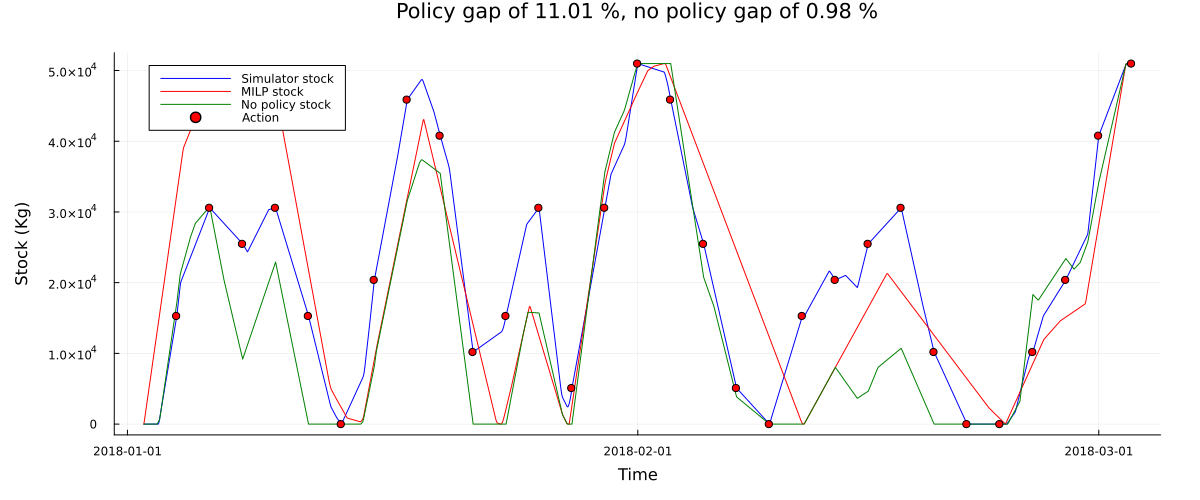

In [244]:
stock_plot = plot(size = (1200, 500), legend = :topleft, margin = 8Plots.mm,
    xlabel = "Time", ylabel = "Stock (Kg)", title = "Policy gap of $policy_gap %, no policy gap of $no_policy_gap %")
plot!(stock_plot, overall_time,
    output_simulation["stock"], label = "Simulator stock", color = :blue) 
plot!(stock_plot, overall_time,
    output_milp["stock"][Not(end)], label = "MILP stock", color = :red)
plot!(stock_plot, overall_time,
    output_no_policy["stock"], label = "No policy stock", color = :green)

scatter!(stock_plot, last_hour_by_period, action_result_by_period, label = "Action", color = :red)

savefig(stock_plot, "plots/stock-period=$period_length-N_EV=$(N_EV)-T=$(T)-N_STATES=$(N_STATES)-N_CLASSES=$(N_CLASSES)-$(string(classification_function)).png")

plot(stock_plot)

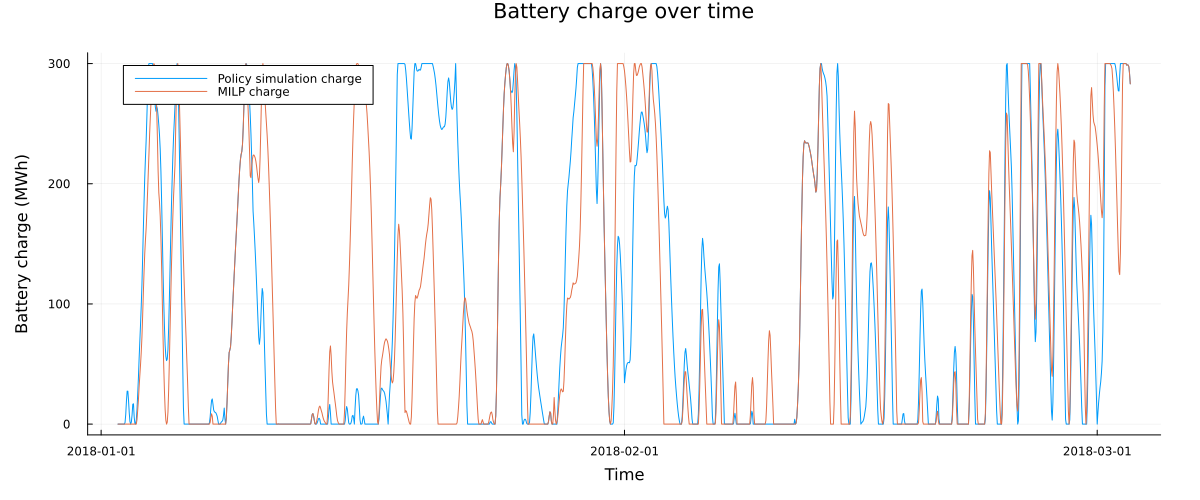

In [245]:
battery_plot = plot(size = (1200, 500), legend = :topleft, margin = 8Plots.mm,
    xlabel = "Time", ylabel = "Battery charge (MWh)", title = "Battery charge over time")
plot!(battery_plot, overall_time, output_simulation["charge"], label = "Policy simulation charge")
plot!(battery_plot, overall_time, output_milp["charge"][Not(end)], label = "MILP charge")
savefig("plots/battery-period=$period_length-N_EV=$(N_EV)-T=$(T)-N_STATES=$(N_STATES)-N_CLASSES=$(N_CLASSES)-$(string(classification_function)).png")

plot(battery_plot)

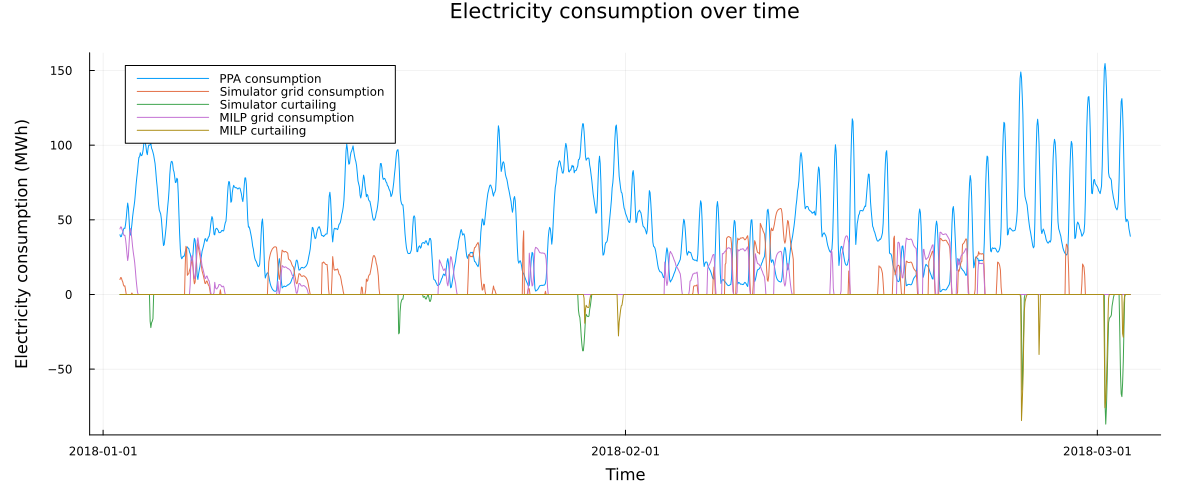

In [246]:
elec_plot = plot(size = (1200, 500), legend = :topleft, margin = 8Plots.mm,
    xlabel = "Time", ylabel = "Electricity consumption (MWh)", title = "Electricity consumption over time")
plot!(elec_plot, overall_time, output_simulation["elec_ppa"], label = "PPA consumption")
plot!(elec_plot, overall_time, output_simulation["elec_grid"], label = "Simulator grid consumption")
plot!(elec_plot, overall_time, -output_simulation["curtailing"], label = "Simulator curtailing")
plot!(elec_plot, overall_time, output_milp["elec_grid"], label = "MILP grid consumption")
plot!(elec_plot, overall_time, -output_milp["curtailing"], label = "MILP curtailing")

savefig("plots/elec-period=$period_length-N_EV=$(N_EV)-T=$(T)-N_STATES=$(N_STATES)-N_CLASSES=$(N_CLASSES)-$(string(classification_function)).png")

plot(elec_plot)

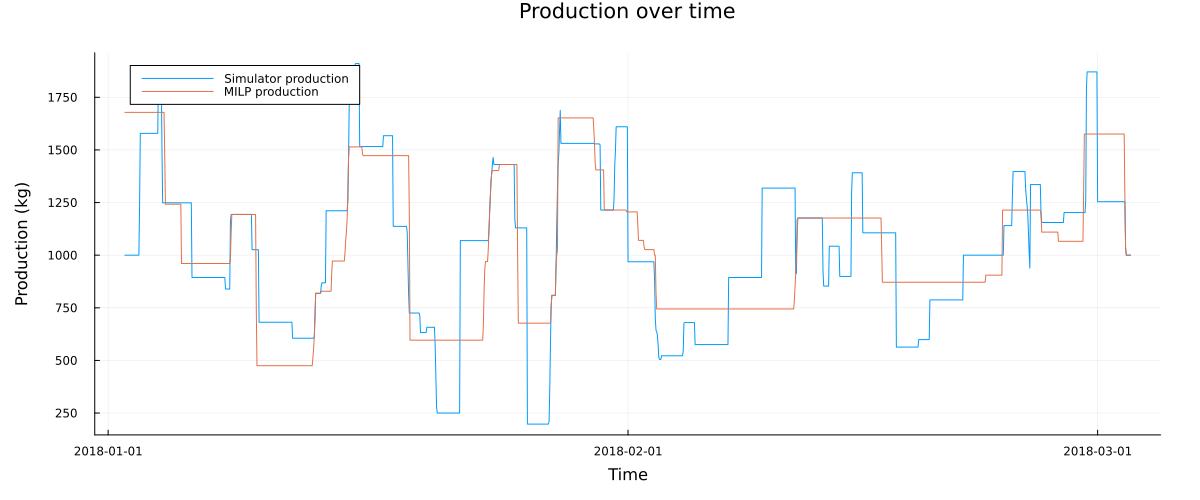

In [247]:
production = plot(size = (1200, 500), legend = :topleft, margin = 8Plots.mm,
    xlabel = "Time", ylabel = "Production (kg)", title = "Production over time")

plot!(production, overall_time, output_simulation["prod"], label = "Simulator production")
plot!(production, overall_time, output_milp["prod"], label = "MILP production")

savefig("plots/production-period=$period_length-N_EV=$(N_EV)-T=$(T)-N_STATES=$(N_STATES)-N_CLASSES=$(N_CLASSES)-$(string(classification_function)).png")

plot(production)